In [1]:
import pandas as pd
import pickle as pck
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set input variables
grp_frag_df_flpath = "/home/antonio/Projects/HlxCnt/BC70/grp_frag_df_clust-70.p"

save_dir = "./"
min_size = 4
## NOTES
# Export dataframe as csv on previous step

## Load dataframe

In [3]:
grp_frag_df = pck.load(open(grp_frag_df_flpath, 'rb')).drop(columns=[0,1])
## NOTES
# Do the drop of reduntant columns at before exporting dataframe

In [4]:
len(grp_frag_df)

592328

## Filtering fragments

In [5]:
print('@ Filtering fragments...')
print(f'  :: starting with {len(grp_frag_df)} fragments')
# 2.1 - Filter fragments
# 2.1.1- Remove extreme values
#print('  > removing extreme values...')
#t_max_cond = grp_frag_df['t_mean']<0.3#0.2
#t_min_cond = grp_frag_df['t_mean']>-0.3
#w_max_cond = grp_frag_df['w_mean']<0.3
#w_min_cond = grp_frag_df['w_mean']>-0.3
#grp_fdf_1 = grp_frag_df.loc[t_max_cond & t_min_cond & w_max_cond & w_min_cond]
#print('  :: ', len(grp_fdf_1), ' fragments remaining')

# filter by size
print(f'  > removing fragments less than {min_size} residues...')
min_size_cond = grp_frag_df["size"] >= min_size
grp_fdf_1 = grp_frag_df.loc[min_size_cond]
print('  :: ', len(grp_fdf_1), ' fragments remaining')

#grp_fdf_1.to_csv(save_dir+"/filtered_frags_1.csv")

#grp_fdf_2.to_csv(save_dir+"/filtered_frags_2.csv")

print('  > removing fragments with high standard deviations...')
c_std_cond = grp_fdf_1['c_std'] <= 0.07
t_std_cond = grp_fdf_1['t_std'] <= 0.01
grp_fdf_2 = grp_fdf_1.loc[c_std_cond & t_std_cond]
print('  :: ', len(grp_fdf_2), ' fragments remaining')
#grp_fdf_3.to_csv(save_dir+"/filtered_frags_3.csv")


@ Filtering fragments...
  :: starting with 592328 fragments
  > removing fragments less than 4 residues...
  ::  356724  fragments remaining
  > removing fragments with high standard deviations...
  ::  39503  fragments remaining


## Explore data

### Check size to standard deviation distribution

(0.0, 0.1)

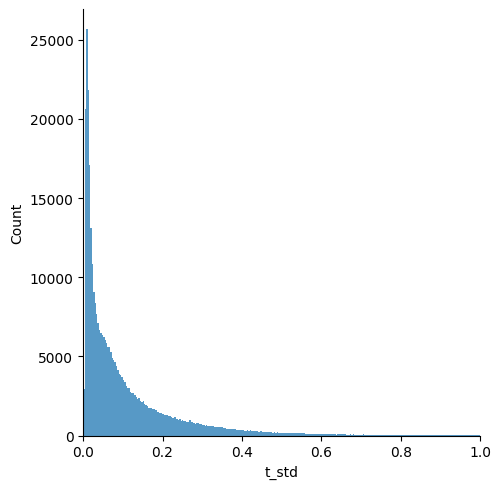

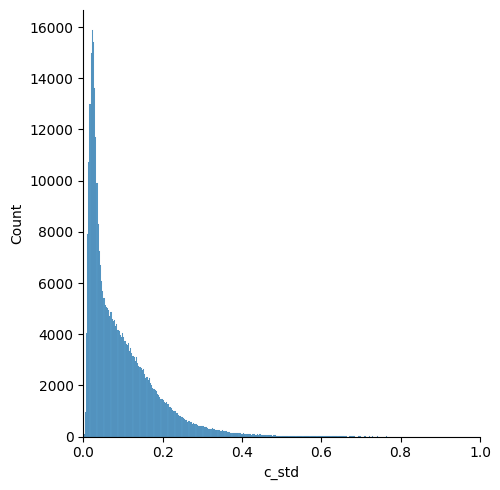

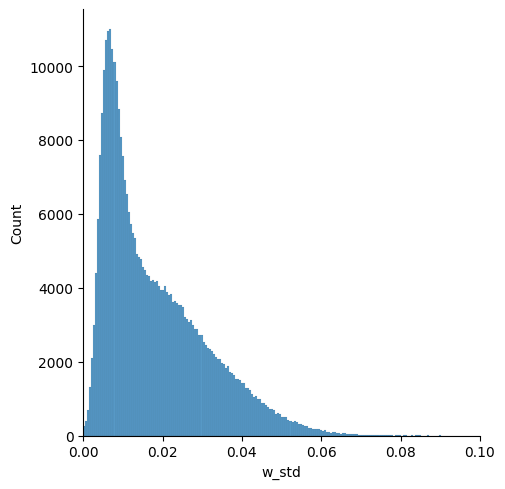

In [8]:
sns.displot(grp_fdf_1["t_std"])
plt.xlim(0,1)

sns.displot(grp_fdf_1["c_std"])
plt.xlim(0,1)

sns.displot(grp_fdf_1["w_std"])
plt.xlim(0,0.1)


(0.0, 1.0)

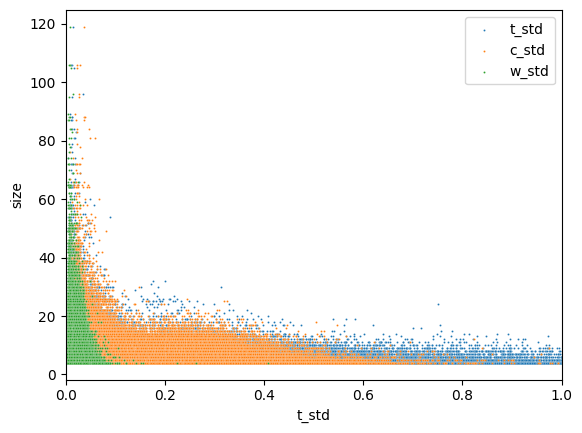

In [7]:
sns.scatterplot(data=grp_fdf_1, x="t_std", y="size", s=2, label="t_std")
sns.scatterplot(data=grp_fdf_1, x="c_std", y="size", s=2, label="c_std")
sns.scatterplot(data=grp_fdf_1, x="w_std", y="size", s=2, label="w_std")
plt.xlim(0,1)


(0.0, 0.8)

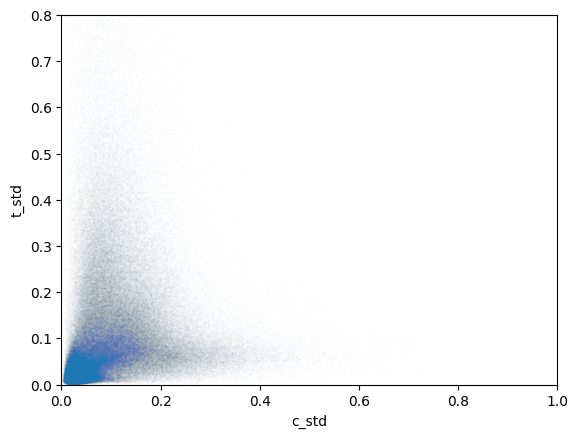

In [14]:
sns.scatterplot(data=grp_fdf_1, x="c_std", y="t_std", alpha=0.01, s=2)
#sns.scatterplot(data=grp_fdf_1, x="c_std", y="size", s=2, label="c_std")
#sns.scatterplot(data=grp_fdf_1, x="w_std", y="size", s=2, label="w_std")
plt.xlim(0,1)
plt.ylim(0, 0.8)

  > removing fragments with high standard deviations...
  ::  172337  fragments remaining


(-0.5, 0.5)

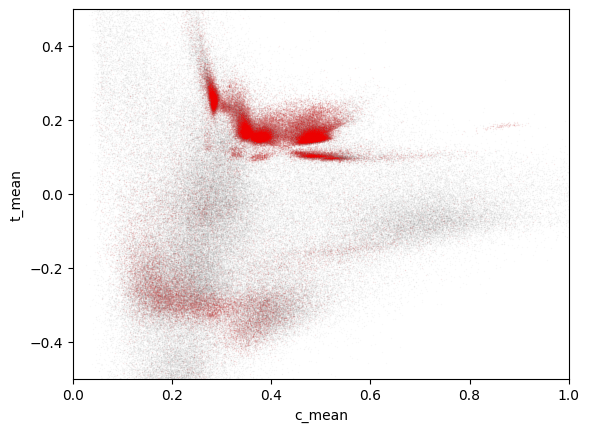

In [26]:
# test std filters
print('  > removing fragments with high standard deviations...')
c_std_cond = grp_fdf_1['c_std'] <= 0.1
t_std_cond = grp_fdf_1['t_std'] <= 0.1
grp_fdf_new = grp_fdf_1.loc[c_std_cond & t_std_cond]
print('  :: ', len(grp_fdf_new), ' fragments remaining')
sns.scatterplot(data=grp_fdf_1, x="c_mean", y="t_mean", s=1, alpha=0.05, c="grey")
sns.scatterplot(data=grp_fdf_new, x="c_mean", y="t_mean", s=1, alpha=0.05, c="red")
plt.xlim(0,1.0)
plt.ylim(-0.5,0.5)


(-0.5, 0.5)

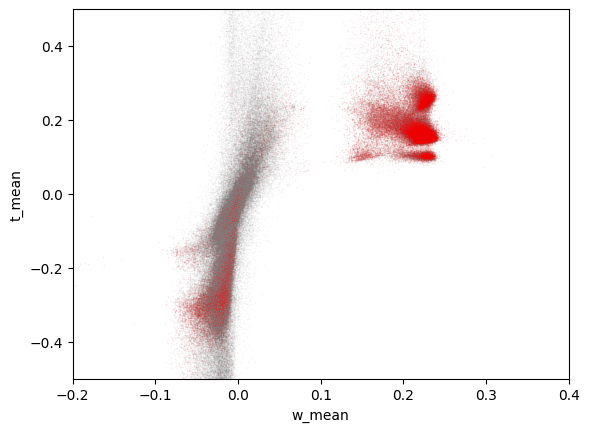

In [30]:
sns.scatterplot(data=grp_fdf_1, x="w_mean", y="t_mean", s=1, alpha=0.05, c="grey")
sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=1, alpha=0.05, c="red")
plt.xlim(-0.2,0.4)
plt.ylim(-0.5,0.5)

In [ ]:
### Check changes due to filtering
#hist load precomputed fragments data
#filtered_frag_1 = pd.read_csv("filtered_frags_1.csv") # only extreme values were filtered
#filtered_frag_2 = pd.read_csv("filtered_frags_2.csv") # filtered by curvature and torsion standard deviations
sns.scatterplot(data=grp_frag_df, x="c_mean", y="t_mean", s=1, alpha=0.1,label="0", c="grey")
sns.scatterplot(data=grp_fdf_1, x="c_mean", y="t_mean", s=1, alpha=0.1,label="1", c="red")
sns.scatterplot(data=grp_fdf_2, x="c_mean", y="t_mean", s=1, alpha=0.5,label="2", c="yellow")
#sns.scatterplot(data=grp_fdf_3, x="c_mean", y="t_mean", s=2, alpha=0.5,label="3", c="blue")
plt.xlim(0,1.0)
plt.ylim(-1.5,1.0)
plt.legend()

In [ ]:
sns.scatterplot(data=grp_frag_df, x="w_mean", y="t_mean", s=1, alpha=0.1,label="0", c="grey")
sns.scatterplot(data=grp_fdf_1, x="w_mean", y="t_mean", s=1, alpha=0.1,label="1", c="red")
sns.scatterplot(data=grp_fdf_2, x="w_mean", y="t_mean", s=2, alpha=0.5,label="2", c="yellow")
plt.xlim(-0.2,0.6)
plt.ylim(-0.8,0.7)
plt.legend()

In [ ]:
# load fragments data
#filtered_frag_1 = pd.read_csv("filtered_frags_1.csv") # only extreme values were filtered
#filtered_frag_2 = pd.read_csv("filtered_frags_2.csv") # filtered by curvature and torsion standard deviations




# Clustering

## Alpha/Pi/3(10) canonical regions

|---------| Alpha/Pi/3(10) canonical region |---------|
@ clustering |w| > 0.1...
   > filtering 
  :: 151732 residues after filtering


(-0.8, 0.7)

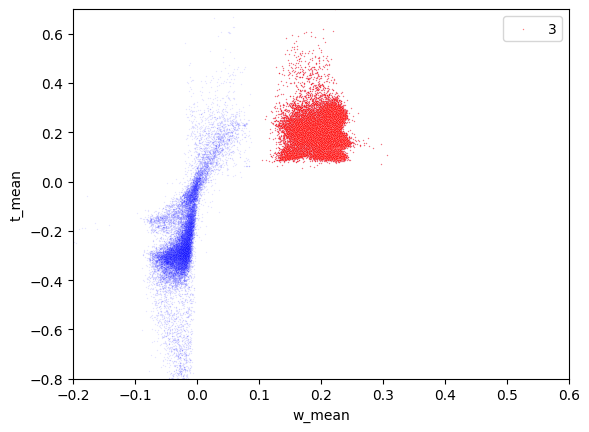

In [36]:

print('|---------| Alpha/Pi/3(10) canonical region |---------|')
# 4 - generate clusters for Pi, Alpha and 3(10)
#   Pi, Alpha and 3(10) helices residues belongs to the region of |w| > 0.1 and
# those  usually forms globular clusters. The strategy for those SSE is:
print('@ clustering |w| > 0.1...')
print('   > filtering ')
wgrtr_1 = grp_fdf_new['w_mean'] >  0.1
wgrtr_2 = grp_fdf_new['w_mean'] < -0.1
df_1 = grp_fdf_new.loc[wgrtr_1]

print(f'  :: {len(df_1)} residues after filtering')

sns.scatterplot(data=grp_fdf_new, x="w_mean", y="t_mean", s=1, alpha=0.1, c="blue")
sns.scatterplot(data=df_1, x="w_mean", y="t_mean", s=1, alpha=0.5,label="3", c="red")
plt.xlim(-0.2,0.6)
plt.ylim(-0.8,0.7)

In [ ]:

# 4.1) consider only frags with wri mean higher than 0.1 and run hdbscan
print('  > running hdbscan [min_cluster_size=',min_cluster_size,']...')
grp_df_wgrtr, clusterer = cluster_grp_frags(grp_fdf_2.loc[wgrtr_1], #| wgrtr_2],
                cols = ['c_mean', 'w_mean', 't_mean'], method='hdbscan',
                min_cluster_size=min_cluster_size)

# 4.2) Compute the membership vectors for the clustering assignment
print('  > computing membership vectors...')
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
grp_df_wgrtr['membership_vec'] = tuple(soft_clusters)

# 4.3) Determinate which points belongs to the core of the clusters
print(f'  > selecting data points belonging to clusters core (Pc_lim = {Pc_LIM})...')
grp_df_wgrtr['is_at_core'] = get_core_labels(grp_df_wgrtr, Pc_LIM=Pc_LIM)
print(grp_df_wgrtr[['membership_vec','is_at_core']])
core_df = grp_df_wgrtr.loc[grp_df_wgrtr['is_at_core']==True]
print('  :: ', len(core_df), 'total fragments selected' )
print(np.unique(core_df['grp_frag_clusters'], return_counts=True))
grp_df_wgrtr.to_csv(save_dir+"/grp_df_wgrtr.csv")
print('   > saving core dataframes at ', save_dir,'...')


## PP2 helix